<center>
    
# Introducción al Machine Learning 2020
# Árboles de decisión, Random Forest y XGBoost 
    
    Práctico: José robledo

# Cabecera

In [1]:
# Manejo de dataframes
import pandas as pd

# operaciones numéricas
import numpy as np

#Graficos
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Métodos de aprendizaje automático
import xgboost as xgb
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import accuracy_score

#datos 
from sklearn import datasets
from sklearn.datasets import load_iris


# Arboles de decisión
En esta sección, vamos a ver cómo funciona un árbol de decisión y luego vamos a utilizar el paquete scikit-learn para realizar un árbol de decisión.

Haremos este ejemplo sobre una base de datos que armaremos en un dataframe utilizando el paquete `Pandas`.

In [2]:
import pandas as pd

data = pd.DataFrame({"Dientes":[True,True,True,False,True,True,True,True,True,False],
                     "Pelo":[True,True,False,True,True,True,False,False,True,False],
                     "Respira":[True,True,True,True,True,True,False,True,True,True],
                     "Piernas":[True,True,False,True,True,True,False,False,True,True],
                     "Especie":["Mamifero","Mamifero","Reptil","Mamifero","Mamifero","Mamifero","Reptil","Reptil","Mamifero","Reptil"]
                     }, 
                    columns=["Dientes","Pelo","Respira","Piernas","Especie"]
                    )

features = data[["Dientes","Pelo","Respira","Piernas"]]
target = data["Especie"]

data

,Dientes,Pelo,Respira,Piernas,Especie
0,True,True,True,True,Mamifero
1,True,True,True,True,Mamifero
2,True,False,True,False,Reptil
3,False,True,True,True,Mamifero
4,True,True,True,True,Mamifero
5,True,True,True,True,Mamifero
6,True,False,False,False,Reptil
7,True,False,True,False,Reptil
8,True,True,True,True,Mamifero
9,False,False,True,True,Reptil


Vemos que la base de datos cuenta con 10 animales, sobre los cuales se ha observado si presentan dientes, si tienen pelo, si respiran y si tienen piernas. La variable dependiente en este caso es la especie. Se desea saber si, a partir de las variables registradas, se puede generar un clasificador que determine si un animal es mamífero o reptil. Para esto utilizaremos un árbol de decisión.

## Implementación

La implementación en python es sencilla. Primero, lo implementaremos con scikit-learn y luego iremos entendiendo qué está haciendo el método de este paquete.

In [3]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion = 'entropy')

model.fit(features,target)

print("The prediction accuracy is: ",model.score(features,target)*100,"%")
#prediction = model.predict(test_features)

The prediction accuracy is:  100.0 %


Podemos graficar el árbol de decisión:

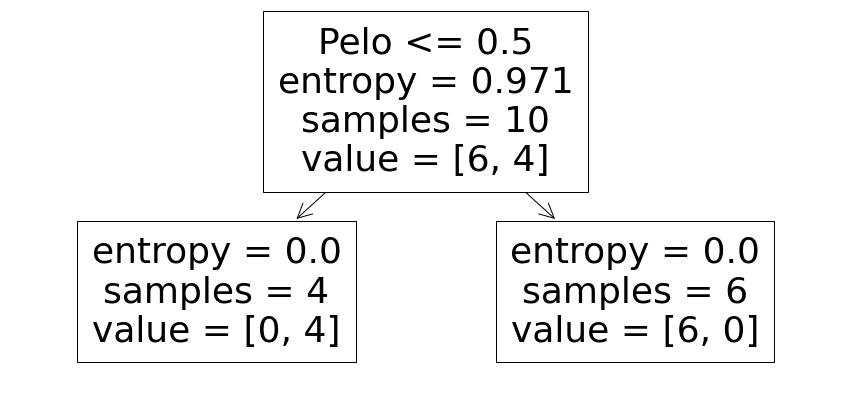

In [4]:
import matplotlib.pyplot as plt
from sklearn import tree
plt.figure(figsize=(15,7))
tree.plot_tree(model,feature_names=["Dientes","Pelo","Respira","Piernas"])
plt.show()

## Ahora entendamos un poco


Entropía $H$:

Medida de impureza de un conjunto de datos. La ganancia de información se refleja en un decrecimiento en la medida de entropía.

Definición: 

$H(Q_m) = - \sum_{k \in target} P_{mk} log_2(P_{mk})$,

donde $Q_m$ son los datos en el nodo $m$ del árbol, la suma se extiende sobre los posibles valores $k$ de la variable respuesta y $P_{mk}$ es la probabilidad condicional que la variable respuesta tome el valor $k$ dado a que estamos en el nodo $m$

In [5]:
def entropia(P):
    '''
    Función que calcula medida de entropía dada una probabilidad P.
    '''
    entropy = - P * np.log2(P)
    return entropy

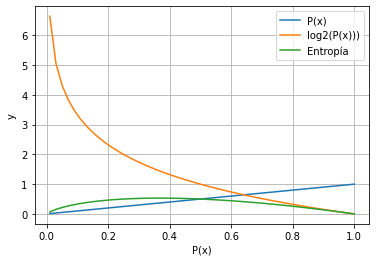

In [6]:
import numpy as np

#Declaramos la figura
plt.figure()

#Agregamos contenido
x = np.linspace(0.01,1)
plt.plot(x,x,label='P(x)')
plt.plot(x,-np.log2(x),label='log2(P(x)))')
plt.plot(x,entropia(x),label='Entropía')

#Agregamos formato
plt.xlabel("P(x)") #Agrega nombre al eje x
plt.ylabel("y") #Agrega nombre al eje y
plt.grid() #muestra la grilla
plt.legend() #muestra las leyendas, definidas con "label" en cada curva.

#mostramos y cerramos la figura
plt.show()

In [7]:
data

,Dientes,Pelo,Respira,Piernas,Especie
0,True,True,True,True,Mamifero
1,True,True,True,True,Mamifero
2,True,False,True,False,Reptil
3,False,True,True,True,Mamifero
4,True,True,True,True,Mamifero
5,True,True,True,True,Mamifero
6,True,False,False,False,Reptil
7,True,False,True,False,Reptil
8,True,True,True,True,Mamifero
9,False,False,True,True,Reptil


Para utilizar la definición de entropía debemos tener una función que estime la probabilidad con la frecuencia relativa.  

In [8]:
def calc_prob(data):
    '''
    Función que calcula la probabilidad de cada clase.
    data : columna categórica de un dataframe de pandas.
    '''
    return data.value_counts()/data.shape[0]
probabilidades = calc_prob(data['Especie'])
probabilidades

Mamifero    0.6
Reptil      0.4
Name: Especie, dtype: float64

Con esta función, podemos calcular la entropía total de los datos en el primer nodo:

In [9]:
entropia_total = entropia(probabilidades[0]) + entropia(probabilidades[1])
#Es lo mismo que:
entropia_total = np.sum([entropia(pi) for pi in probabilidades])
print(f'La entropia total es {round(entropia_total,3)}')

La entropia total es 0.971


Podemos ver que este valor coincide con el que declara el método `DecisionTreeClassifier` de `scikit-learn` en el árbol de decisión que obtuvimos anteriormente.


Ahora, **¿Por qué eligió la variable pelo para ramificar? ¿Cómo lo hizo?**

Para responder esto, calculemos la ganancia de entropía para cada variable descriptiva. Esto lo podemos pensar como:

$GananciaEntropia(variable_d) = Entropia_{total} - Entropia(variable_d)$

Lo que se puede escribir como:

$GananciaEntropia(variable_d) = Entropia_{total} - \sum_{t \in variable_d} P(variable_d=t) * H(variable_d=t) $

que es igual a:

$GananciaEntropia(variable_d) = Entropia_{total} - \sum_{t \in variable_d} P(variable_d=t) * (-\sum_{k \in target} P(target=k \cap variable_d = t)) * \log_2(P((target=k \cap variable_d = t)))$

In [10]:
data[data.Dientes == 1]

,Dientes,Pelo,Respira,Piernas,Especie
0,True,True,True,True,Mamifero
1,True,True,True,True,Mamifero
2,True,False,True,False,Reptil
4,True,True,True,True,Mamifero
5,True,True,True,True,Mamifero
6,True,False,False,False,Reptil
7,True,False,True,False,Reptil
8,True,True,True,True,Mamifero


In [11]:
data[data.Dientes == 0]

,Dientes,Pelo,Respira,Piernas,Especie
3,False,True,True,True,Mamifero
9,False,False,True,True,Reptil


In [12]:
#Probabilidades de ser mamífero o reptil dado que tiene dientes
P_especie_dientes = calc_prob(data[data.Dientes == 1]['Especie'])
#Probabilidades de ser mamífero o reptil dado que no tiene dientes
P_especie_nodientes = calc_prob(data[data.Dientes == 0]['Especie'])
#Probabilidad de tener dientes
P_dientes = calc_prob(data['Dientes'])

#entropias
entropia_dientes = P_dientes[1] * (entropia(P_especie_dientes[0]) + entropia(P_especie_dientes[1])) \
                +  P_dientes[0] * (entropia(P_especie_nodientes[0]) + entropia(P_especie_nodientes[1]))

entropia_dientes

0.963547202339972

In [13]:
#información ganada
entropia_total - entropia_dientes 

0.007403392114696539

In [14]:
def ganancia_de_info(var,data=data,respuesta='Especie'):
    '''
    Función que calcula la ganancia de información utilizando la entropía como medida
    de información.
    
    variables de entrada:
    var (str): nombre de la variable sobre la cuál vamos a calcular la ganancia de la información.
    data (dataFrame): el conjunto de datos de donde sacar la varianza
    respuesta (str): nombre de la variable respuesta
    
    Devuelve la ganancia de información (float)
    '''
    probabilidades = calc_prob(data[respuesta])
    entropia_total = np.sum([entropia(pi) for pi in probabilidades])
    P_especie_var = calc_prob(data[respuesta][data[var] == 1])
    P_especie_novar = calc_prob(data[respuesta][data[var] == 0])
    P_var = calc_prob(data[var])
    
    entropia_var = P_var[1] * np.sum([entropia(pi) for pi in P_especie_var]) \
                    +  P_var[0] * np.sum([entropia(pi) for pi in P_especie_novar])
    return entropia_total - entropia_var

print(f'ganancia de información variable dientes: {ganancia_de_info("Dientes"):.3f}')
print(f'ganancia de información variable pelo: {ganancia_de_info("Pelo"):.3f}')
print(f'ganancia de información variable respira: {ganancia_de_info("Respira"):.3f}')
print(f'ganancia de información variable piernas: {ganancia_de_info("Piernas"):.3f}')

ganancia de información variable dientes: 0.007
ganancia de información variable pelo: 0.971
ganancia de información variable respira: 0.144
ganancia de información variable piernas: 0.557


Probemos nuestro clasificador con algunos animales nuevos:

In [15]:
#recordemos que las variables son ["Dientes","Pelo","Respira","Piernas"]
animal_raro_1 = [0,0,0,0]
animal_raro_2 = [1,1,0,0]
model.predict([animal_raro_1,animal_raro_2])

array(['Reptil', 'Mamifero'], dtype=object)

In [16]:
model.predict_proba([[1,0,0,0]])

array([[0., 1.]])

## Ejemplo de árbol de decisión más complejo: datos Iris

[scikit-learn](https://scikit-learn.org/stable/modules/tree.html)

['setosa' 'versicolor' 'virginica']
The prediction accuracy is:  100.0 %


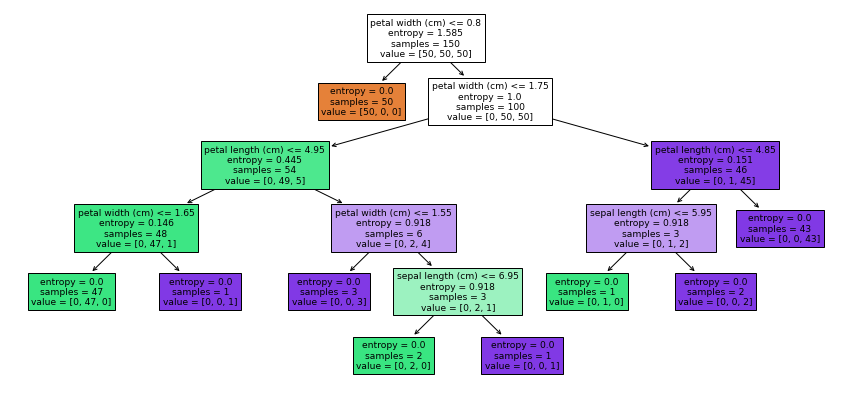

In [41]:
#importamos lo necesario
from sklearn.datasets import load_iris
from sklearn import tree
import matplotlib.pyplot as plt
import pandas as pd
#cargamos los datos
iris = load_iris()
X, y = iris.data, iris.target

print(iris.target_names)
#armamos el árbol de decisión
clf = tree.DecisionTreeClassifier(criterion='entropy',random_state=1)
clf = clf.fit(X, y)

print("The prediction accuracy is: ",clf.score(X,y)*100,"%")
#graficamos
plt.figure(figsize=(15,7))
tree.plot_tree(clf,
               feature_names=iris.feature_names,
               filled=True)
plt.show()

In [42]:
#armamos dataframe para visualizar
df = pd.DataFrame(X,columns=iris.feature_names)
df['Especie'] = y
df['Especie'].replace({0:'setosa', 1:'versicolor', 2:'virginica'},
                      inplace=True)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Especie
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


Verificamos

In [43]:
condicion_logica_1 = df['petal width (cm)']>=0.8
condicion_logica_2 = df['petal width (cm)']>=1.75
df[condicion_logica_1 & condicion_logica_2].shape

(46, 5)

Podemos predecir la especie de una nueva observación ficticia. Para poner unos valores razonables, podemos primero ver las distribuciones de las variables y luego elegir valores acorde a las distribuciones. 

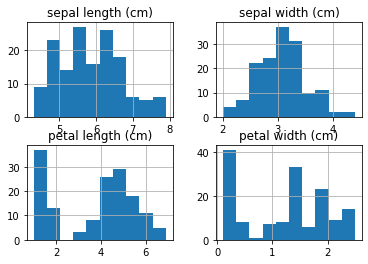

In [44]:
df.hist()
plt.show()

In [45]:
#Recordar orden de entrada: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
clf.predict_proba([[6.0,3.0,4.2,1.2]])
#Recordar orden de salida: ['setosa' 'versicolor' 'virginica']

array([[0., 1., 0.]])

Nuestro árbol de decisión, basándose en la estructura de los datos al entrenarse, predice que la nueva observación corresponde a la especie versicolor.

Podemos ir un paso más allá, y graficar las fronteras de decisión. A modo de simplificación, pensemos que si queremos graficar en 2 dimensiones, y tenemos cuatro variables de entrada, podemos fijar dos variables de entrada y luego ver cómo es la frontera de decisión para las dos variables que no fijamos. Como ejemplo, fijaremos la longitud del pétalo en 4.85, el áncho del pétalo en 1.76 y veremos cómo es la frontera de decisión para las características del sépalo dado estos valores de características del pétalo. Pueden jugar con distintos valores para ver cómo cambia.

Esto es mucho más complejo, no lo vamos a analizar en detalle, pero les dejo un código que lo puede hacer, como para que vean el potencial de la herramienta gráfica:

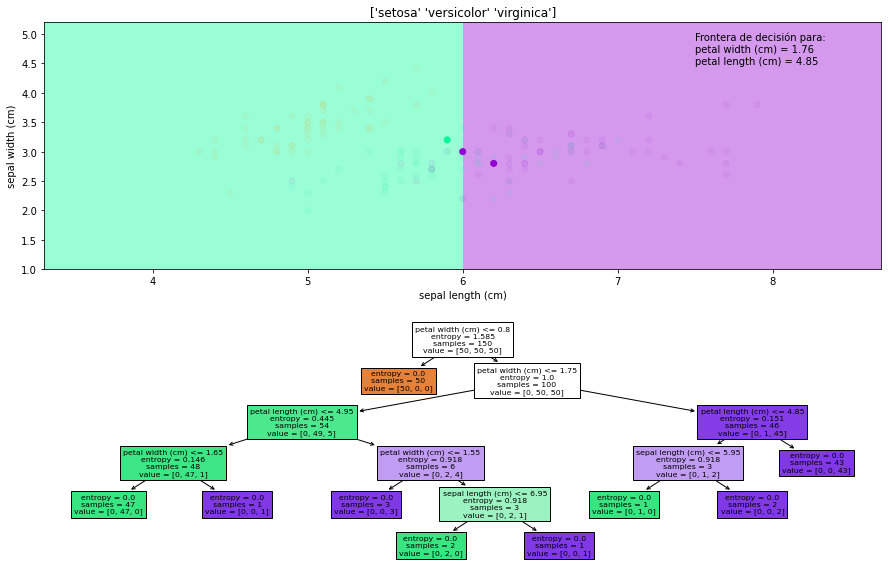

In [46]:
import numpy as np
from matplotlib.colors import ListedColormap

long_petalo = 4.85
ancho_petalo = 1.76

#Condición lógica
condition = (df['petal length (cm)']<=long_petalo) & (df['petal width (cm)']>=ancho_petalo)

#defino los colores necesarios para que quede más bonito y consistente con los colores del árbol.
cmap = ListedColormap(["mediumspringgreen", "darkviolet"])
ycolor = []
for caso in y:
    if caso == 0:
        ycolor.append("orange")
    elif caso == 1:
        ycolor.append("mediumspringgreen")
    elif caso == 2:
        ycolor.append("darkviolet")
    else:
        ycolor.append(np.nan)

# Busco los valores máximos y mínimos de las variables de sépalo        
x_min, x_max = iris.data[:, 0].min() - 1, iris.data[:, 0].max() + 1
y_min, y_max = iris.data[:, 1].min() - 1, iris.data[:, 1].max() + 1

# Armo grilla de puntos donde vamos a predecir para armar las regiones
xx1, xx2 = np.meshgrid(np.arange(x_min, x_max, 0.2),
                     np.arange(y_min, y_max, 0.2))

# fijo los valores de las variables de pétalo. Los voy a necesitar
# ya que el modelo que entrenamos toma de entrada las 4 variables del
# conjunto de datos
xx3 = [long_petalo for i in xx1.ravel()]
xx4 = [ancho_petalo for i in xx1.ravel()] 

# Realizo la predicción de los puntos de la grilla. Acá uso ravel para 
# "alinear" todos los puntos de la grilla en un solo array, para evaluar
# el modelo en cada punto. En este momento tenemos un array unidimensional.  
Z = clf.predict(np.c_[xx1.ravel(),xx2.ravel(),xx3,xx4])
# Volver a poner cada punto en la grilla espacial. En este momento tenemos
# un array bidimensional.
Z = Z.reshape(xx1.shape)

# Armamos la figura
plt.figure(figsize=(15,10))
# Este es un ejemplo de una figura con 2 gráficos adentro. Para esto usamos
# subplot. Le decimos cuantas filas queremos, cuantas columnas y en dónde vamos
# a poner el gráfico que sigue a continuación. El 1 final dice que lo vamos a poner
# en el primer lugar.
plt.subplot(2,1,1)
# Usamos el método de contorno de pyplot llamado contourf que genera un gráfico de contorno 
# y además rellena entre contornos (la f viene de fill). Recuerden usar ? para ver info.
plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)

#Agregamos los datos que cumplen con la condición que hemos puesto
plt.scatter(df['sepal length (cm)'][condition],
            df['sepal width (cm)'][condition], c=np.array(ycolor)[condition])

#Agregamos todos los otros datos, pero más suavecitos. El valor de alpha determina la transparencia.
plt.scatter(df['sepal length (cm)'],
            df['sepal width (cm)'], c=ycolor,alpha=0.05)
#Agregamos formato al primer gráfico
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')

#Agremos texto
plt.text(7.5,4.3,f'''Frontera de decisión para:
petal width (cm) = {ancho_petalo}
petal length (cm) = {long_petalo}
''')
plt.title(str(iris.target_names))

# Acá comienza el segundo gráfico dentro de la figura. Eso indica el número 2 final.
# Sólo agregamos el árbol de decisión para comparar
plt.subplot(2,1,2)
tree.plot_tree(clf,
               feature_names=iris.feature_names,
               filled=True)
plt.show()

Si nos fijamos en el gráfico anterior, vemos que con los valores fijados y la condición lógica que estamos planteando estamos en la rama de la derecha del árbol de decisión. En particular, los 3 puntos que se colorean con la condición lógica corresponden con los tres casos que salen del nodo "sepal length(cm) <= 5.95".

### Regiones de decisión: ahondemos más

Para facilitar la comprensión, lo que vamos a hacer es sólo generar un modelo de clasificación teniendo en cuenta únicamente las características del sépalo. Como son dos variables, podremos ver exactamente las regiones de decisión en un gráfico bidimensional (sin tener que fijar las otras variables).

In [50]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

The prediction accuracy is:  92.66666666666666 %


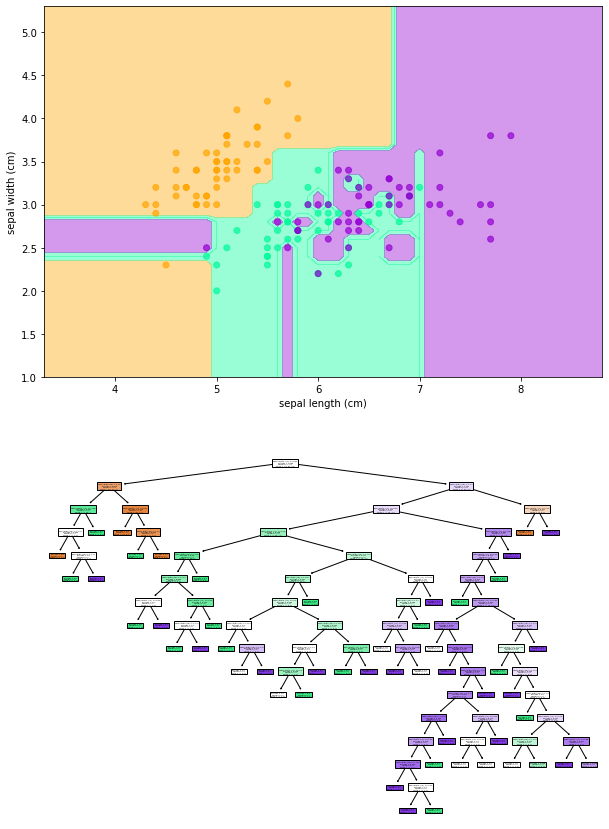

In [51]:
X2 = X[:,:2]
clf2 = tree.DecisionTreeClassifier(criterion='entropy',
                                   random_state=1)
clf2.fit(X2, y)

print("The prediction accuracy is: ",clf2.score(X2,y)*100,"%")
# Busco los valores máximos y mínimos de las variables de sépalo        
x_min, x_max = iris.data[:, 0].min() - 1, iris.data[:, 0].max() + 1
y_min, y_max = iris.data[:, 1].min() - 1, iris.data[:, 1].max() + 1

# Armo grilla de puntos donde vamos a predecir para armar las regiones
xx1, xx2 = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z2 = clf2.predict(np.c_[xx1.ravel(),xx2.ravel()])
Z2 = Z2.reshape(xx1.shape)

plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
cmap = ListedColormap(["orange","mediumspringgreen", "darkviolet"])
plt.contourf(xx1, xx2, Z2, alpha=0.4, cmap=cmap, levels=3)

#Agregamos todos los otros datos, pero más suavecitos. El valor de alpha determina la transparencia.
plt.scatter(df['sepal length (cm)'],
            df['sepal width (cm)'], c=ycolor,alpha=0.7)
#Agregamos formato al primer gráfico
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')


plt.subplot(2,1,2)
tree.plot_tree(clf2,
               feature_names=iris.feature_names[:2],
               filled=True)
plt.show()

Como no se entiende nada del gráfico del árbol de decisión, vamos a utilizar el método `export_text` del módulo `tree` de `sklearn` que permite visualizar el árbol de decisión en texto. A partir de inspeccionar el árbol de decisión, podemos entender la forma de las regiones de decisión.

In [55]:
print(tree.export_text(clf2,feature_names=iris.feature_names[:2]))

|--- sepal length (cm) <= 5.55
|   |--- sepal width (cm) <= 2.80
|   |   |--- sepal length (cm) <= 4.95
|   |   |   |--- sepal width (cm) <= 2.35
|   |   |   |   |--- class: 0
|   |   |   |--- sepal width (cm) >  2.35
|   |   |   |   |--- sepal width (cm) <= 2.45
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- sepal width (cm) >  2.45
|   |   |   |   |   |--- class: 2
|   |   |--- sepal length (cm) >  4.95
|   |   |   |--- class: 1
|   |--- sepal width (cm) >  2.80
|   |   |--- sepal length (cm) <= 5.35
|   |   |   |--- class: 0
|   |   |--- sepal length (cm) >  5.35
|   |   |   |--- sepal width (cm) <= 3.20
|   |   |   |   |--- class: 1
|   |   |   |--- sepal width (cm) >  3.20
|   |   |   |   |--- class: 0
|--- sepal length (cm) >  5.55
|   |--- sepal width (cm) <= 3.70
|   |   |--- sepal length (cm) <= 6.25
|   |   |   |--- sepal length (cm) <= 5.75
|   |   |   |   |--- sepal width (cm) <= 2.85
|   |   |   |   |   |--- sepal width (cm) <= 2.55
|   |   |   |   |   |   |--- sep

Fuentes:

[Fuente 1: Arboles de decisión en scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

[Fuente 2: ejemplo en detalle](https://www.python-course.eu/Decision_Trees.php)


# Random Forest

Uno de los principales problemas de los árboles de decisión es el sobreajuste a los datos de entrenamiento. Suelen tener sesgo chico pero su varianza suele ser muy grande. La manera de sobrepasar este problema es utilizar el método de Random Forest. 


Random Forest en cierto sentido promedia múltiples árboles de decisión, entrenados con distintas partes del conjunto de datos de entrenamiento, con el objetivo de reducir la varianza.

El problema de este método es que se pierde la interpretabilidad tan clara que tiene un árbol de decisión acerca de cómo el algoritmo toma la decisión de clasificación o regresión. Sin embargo, suele exponenciar la performance del modelo final.

El método utiliza el concepto de "Bagging", que se traduce literal a "embolsar", pero que refiere a tomar puequeñas muestras con remplazo del conjunto de datos original. Podemos pensar al conjunto de datos original de entrenamiento como una bolsa con elementos adentro, y lo que hacemos es tomar  bolsitas de menor tamaño para realizar distintos árboles de decisión. Esto se hace secuencialmente, es decir: tomamos una bolsita, entrenamos un árbol de decisión con estos datos, luego reponemos la bolsita en la bolsa original y volvemos a tomar otra bolsita para generar otro árbol de decisión. Esto se repite $B$ veces y luego lo que se hace es promediar las probabilidades predichas por cada árbol en los $B$ árboles obtenidos (en el caso de regresión) o de fijarse cuál es la clase o nivel más votado (en el caso de clasificación).

Random forest se diferencia del método de Bagging al incorporar además la selección de un subconjunto de las variables en cada iteración. Esto evita la correlación entre los distintos árboles de decisión. Además, permite hacer una selección de variables relevantes ya que se puede obtener una importancia relativa de cada variable en la predicción. Esta mezcla de distintos modelos estadísticos y métodos de aprendizaje automático para obtener mejor performance predictiva caracteriza a los métodos llamados de ensamble o *ensemble methods*. Estamos mezclando varios modelos con tal de aumentar la capacidad predictiva del modelo global.

Como pueden ir dándose una idea, estos métodos recién pudieron ser útiles con el avance de la tecnología de las computadoras actuales. Las primeras ideas referidas a random forests fueron propuestas en 1995 y la extensión del algoritmo que se utiliza al día de hoy se patentó en 2006.

## Ejemplifiquemos sobre datos: de nuevo, Iris

In [58]:
from sklearn import datasets

#Cargamos los datos
iris = datasets.load_iris()
print(iris.target_names)
print(iris.feature_names)

['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


Volvemos a armar el dataframe:

In [59]:
import pandas as pd
df=pd.DataFrame({
    'sepal length':iris.data[:,0],
    'sepal width':iris.data[:,1],
    'petal length':iris.data[:,2],
    'petal width':iris.data[:,3],
    'Especie':iris.target
})

print(df.shape)
df.head()

(150, 5)


,sepal length,sepal width,petal length,petal width,Especie
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Separamos las columna de la variable dependiente de las independientes. Además separamos los datos en conjunto de entrenamiento y de prueba.

In [61]:
import sklearn

In [64]:
from sklearn.model_selection import train_test_split

X=df[['sepal length', 'sepal width', 'petal length', 'petal width']]  # Features
y=df['Especie']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=1,
                                                    stratify=y)

Ahora entrenamos en el conjunto de datos de entrenamiento y luego realizamos predicciones sobre el conjunto de datos de prueba.

In [76]:
%%time
from sklearn.ensemble import RandomForestClassifier

#Creamos un clasificador tipo Random forest de scikit-learn
clf=RandomForestClassifier(n_estimators=100)
#Entrenamos al modelo con los datos de entrenamiento y luego predecimos con el testeo.
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

Wall time: 306 ms


Luego del entrenamiento podemos exactitud (Accuracy) del clasificador 

In [77]:
from sklearn import metrics
# Cuan frecuente es correcta la clasificación?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9777777777777777


Podemos ver la matriz de confusión:

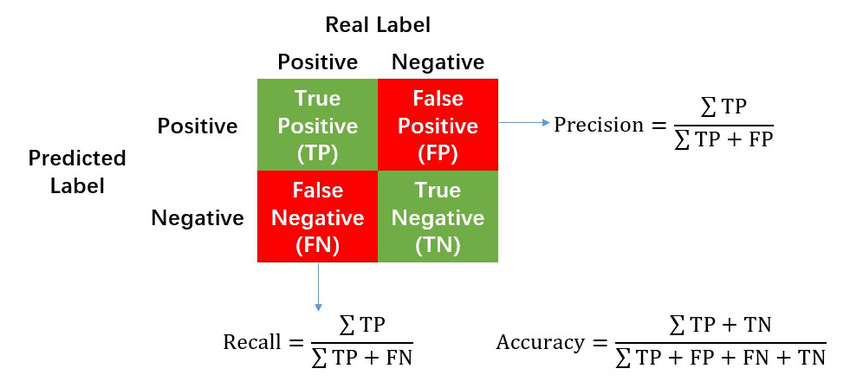

In [78]:
from IPython.display import Image
Image('./images/confusion_matrix.png',width=500) 

In [80]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

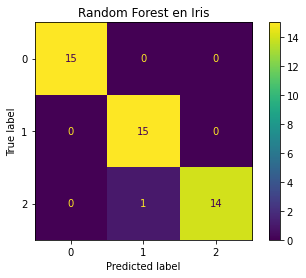

In [79]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,X_test,y_test)
plt.title('Random Forest en Iris')
plt.show()

Veamos la predicción de un caso en particular, donde la longitud del sepalo sea 3, su ancho 5, la longitud del pétalo sea 4 y su ancho sea 2:

In [84]:
prueba = clf.predict([[3, 5, 4, 2],[1,1,1,1]])
#recordemos que 0='setosa', 1='versicolor' y 2='virginica'

In [85]:
def mapear_clases(x):
    clases_dict={
        0 : 'setosa',
        1 : 'versicolor',
        2 : 'virginica'
    }
    return [clases_dict[i] for i in x]


mapear_clases(prueba)     

['versicolor', 'setosa']

Ahora podemos ver la importancia de las variables para la clasificación:

In [82]:
feature_imp = pd.Series(clf.feature_importances_,index=iris.feature_names).sort_values(ascending=False)
feature_imp

petal length (cm)    0.450548
petal width (cm)     0.419180
sepal length (cm)    0.102826
sepal width (cm)     0.027446
dtype: float64

lo cual lo podemos visualizar:

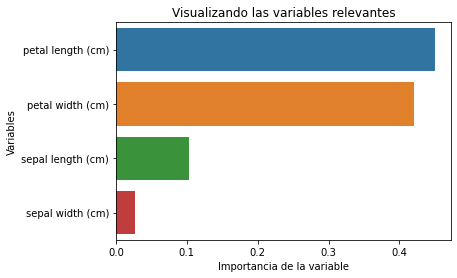

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# creamos el gráfico de barras
sns.barplot(x=feature_imp, y=feature_imp.index)
# agregamos estilo
plt.xlabel('Importancia de la variable')
plt.ylabel('Variables')
plt.title("Visualizando las variables relevantes")

#mostramos y cerramos gráfico
plt.show()

# XGBoost: Extreme Gradient Boosting

En este método se optimiza una función de pérdida. Se utiliza algún método de aprendizaje débil, como los árboles de decisión o CART, pero a través de un ensamble (modelo aditivo). 

En modelos de redes neuronales, se utiliza el descenso por el gradiente para minimizar el conjunto de parámetros del modelo. Luego de calcular la función de pérdida o error, los parámetros se actualizan a modo de minimizar la función de error. 

En este caso, en vez de tener parámetros, tenemos los sub-modelos (arboles de decisión). Se calcula también una función de pérdida, pero para realizar el descenso por el gradiente, se suma un árbol al modelo que reduce la pérdida (es decir, que sigue el gradiente). Esto se obtiene al parametrizar el árbol de decisión y luego modificar estos parámetros a modo de reducir la función de pérdida residual.

Por lo tanto, la diferencia entre el método de Random Forest y el de Gradient Boosting radica en cómo se entrena el modelo aditivo. Pero el modelo aditivo en ambos casos usa el mismo modelo débil: el árbol de decisión.

Sin entrar en más detalles, apliquemos el método sobre un nuevo conjunto de datos

### Dataset PIMA diabetes

Variables: 

1- Embarazos (Número de embarazos)

2- Glucosa (Concentración de glucosa en plasma)

3- Presion (Presión sanguínea diastólica mm Hg)

4- EspesorPiel (Espesor de la piel doblada del trícep (mm))

5- insulina (muU/ml)

6- BMI (índice de masa corporal (Kg/(altura en metros)^2))

7- Diabetes Pedegree Function

8- Edad

9- Resultado


In [86]:
import numpy as np
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

dataset = pd.read_csv('datos/pima-indians-diabetes.csv',
                      delimiter=',',
                      names=['Embarazos',
                              'Glucosa',
                              'Presion',
                              'EspesorPiel',
                              'Insulina',
                              'BMI',
                              'Pedegree',
                              'Edad',
                              'Resultado'
                              ]
                      )
dataset

,Embarazos,Glucosa,Presion,EspesorPiel,Insulina,BMI,Pedegree,Edad,Resultado
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Separamos al conjunto de datos en las variables independientes y dependientes y luego los separamos en conjunto de entrenamiento y de prueba. Usamos una semilla de números aleatorios para que a todos nos de el mismo resultado (repitibilidad).

In [87]:
#Separamos variables independientes de dependiente.
X = dataset.drop('Resultado',axis=1)
y = dataset['Resultado']

#elegimos semilla
semilla = 7
#Elegimos el tamaño del conjunto de prueba
test_size = 0.2

#Armamos los distintos conjuntos de datos de entrenamiento y de prueba.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=test_size,
                                                    random_state=semilla)

Para resumir esta sección y comparar los algoritmos vistos, vamos a entrenar tres modelos distintos y compararlos. Por un lado vamos a utilizar el Extreme Gradient Boosting Classifier (XGBoost) que utiliza árboles de decisión como modelo débil (Modelo 1). También utilizaremos el algoritmo XGBoostRF que utiliza random forests como modelo débil (Modelo 2) y por último compararemos con el Random Forest de la sección anterior (Modelo 3).  

Ajustamos los distintos modelos y comparamos (tener en cuenta que aquí no se están optimizando los hiperparámetros de cada modelo):

In [88]:
model1 = XGBClassifier(eval_metric='error',
                       n_estimators=100,
                      use_label_encoder=False,
                      eta=0.01,
                      subsample=0.8,
                      random_state=1)
model2 = XGBRFClassifier(eval_metric='error',
                         n_estimators=100,
                        use_label_encoder=False,
                        eta=0.1,
                        subsample=0.8,
                        random_state=1)

model3 = RandomForestClassifier(n_estimators=100,
                                random_state=1)
#Entrenamos al modelo con los datos de entrenamiento y luego predecimos con el testeo.

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

#Predicciones
y_pred1 = model1.predict(X_test)
predictions1 = [round(value) for value in y_pred1]

y_pred2 = model2.predict(X_test)
predictions2 = [round(value) for value in y_pred2]

y_pred3 = model3.predict(X_test)
predictions3 = [round(value) for value in y_pred3]

#Calculamos la precisión
accuracy1 = accuracy_score(y_test, predictions1)
print("Accuracy XGBoost: %.2f%%" % (accuracy1 * 100.0))
accuracy2 = accuracy_score(y_test, predictions2)
print("Accuracy XGRFBoost: %.2f%%" % (accuracy2 * 100.0))
accuracy3 = accuracy_score(y_test, predictions3)
print("Accuracy RandomForest: %.2f%%" % (accuracy3 * 100.0))


Accuracy XGBoost: 79.87%
Accuracy XGRFBoost: 80.52%
Accuracy RandomForest: 78.57%


C:\Anaconda3\envs\MEA\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Todos los algoritmos obtienen una precisión mayor al 75% para determinar si el o la paciente tiene diabetes.

Finalmente podemos ver las matrices de confusión de cada modelo utilizando el método `plot_confusion_matrix` del paquete `metrics` de sklearn.

C:\Anaconda3\envs\MEA\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Anaconda3\envs\MEA\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


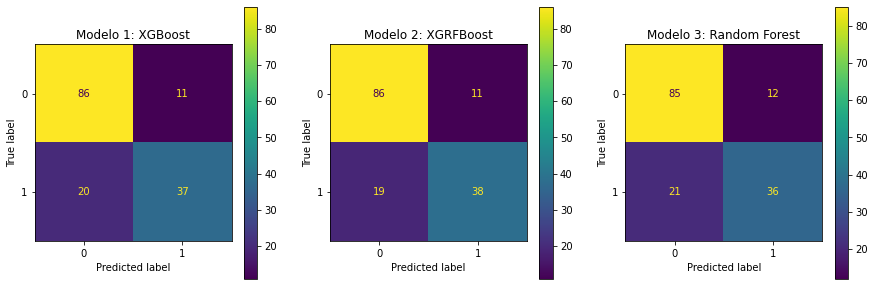

In [89]:
from sklearn.metrics import plot_confusion_matrix
plt.figure(figsize=(15,5))

ax1=plt.subplot(1,3,1)
plot_confusion_matrix(model1,X_test,y_test,ax=ax1)
plt.title('Modelo 1: XGBoost')

ax2=plt.subplot(1,3,2)
plot_confusion_matrix(model2,X_test,y_test,ax=ax2)
plt.title('Modelo 2: XGRFBoost')

ax3=plt.subplot(1,3,3)
plot_confusion_matrix(model3,X_test,y_test,ax=ax3)
plt.title('Modelo 3: Random Forest')

plt.show()

Fuentes XGBoost

[fuente 3: introducción a xgboost](https://kehuiyao.github.io/2019/03/23/xgboost-introduction/)

[fuente 4: tutorial de xgboost](https://medium.com/@jboscomendoza/tutorial-xgboost-en-python-53e48fc58f73)
